In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


# **Problem Overview**

In this competition, we're tasked with building a binary classifier to detect whether a Reddit comment violates a specific rule. While the training data contains only two rules, the test data introduces unseen rules, requiring our model to generalize well.

# **Step1: Load and Explore the Data**

In [2]:
 # For data Visualization e.g histogram, barcharts
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [3]:
# load dataset
train_data = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
test_data = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')

train_data.head() # Display the first five rows of the training dataset 

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


In [4]:
print('Train_shape:',train_data.shape)
print('Test_shape:',test_data.shape)

Train_shape: (2029, 9)
Test_shape: (10, 8)


**Basic Exploratory Data Analysis**

Display the distribution of the target variables(rule_violation). This helps us understand class imbalance e.g how many comments violated the rules vs not violated.

In [5]:
print(train_data['rule_violation'].value_counts())

rule_violation
1    1031
0     998
Name: count, dtype: int64


Show how many examples come from each subreddit. Useful for checking if data is dominated by certain communities.

In [6]:
print(train_data['subreddit'].value_counts())

subreddit
legaladvice         213
AskReddit           152
soccerstreams       139
personalfinance     125
relationships       106
                   ... 
fantasyfootball       1
PurplePillDebate      1
changemyview          1
IAmA                  1
TheSilphRoad          1
Name: count, Length: 100, dtype: int64


**Visualizing the Distribution of Comment Lengths:** I create a new feature 'body_length' to capture the number of characters in each comment. This helps understand the range and frequency of comment lengths in the dataset. Longer or shorter comments may correlate with rule violations and can be an important feature.


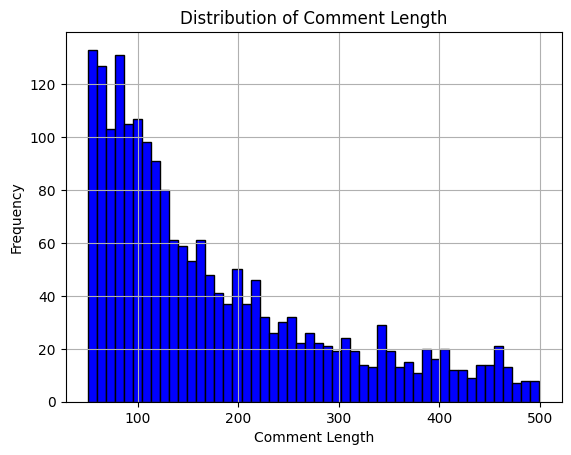

In [7]:
train_data['body_length'] = train_data['body'].str.len()
#train_data['body_length'].value_counts()

train_data['body_length'].hist(bins=50, color='blue',edgecolor='black')
plt.title('Distribution of Comment Length')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

# **Step 2: Preprocessing and Text Cleaning** 

**Word Cloud for Rule Text**

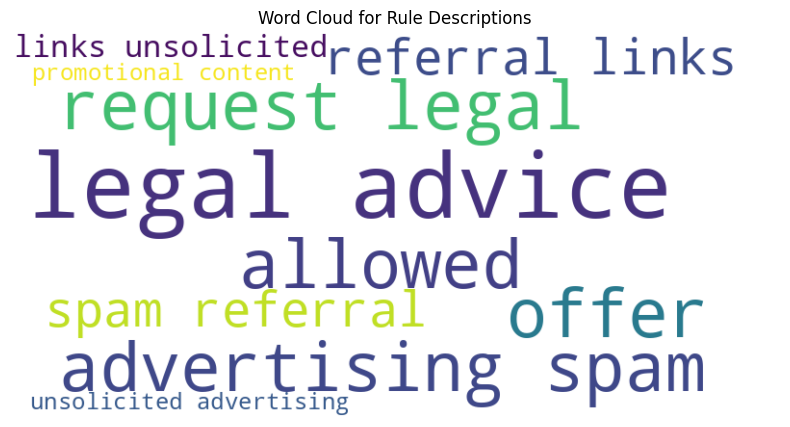

In [8]:
# Generate word cloud for rules
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"\[.*?\]|\(.*?\)", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_data['rule_clean'] = train_data['rule'].apply(clean_text)

# Combine all cleaned rules
all_rules_text = " ".join(train_data['rule_clean'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=ENGLISH_STOP_WORDS).generate(all_rules_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Rule Descriptions')
plt.show()

# Step 3: Processing 

In [9]:
# Clean text columns 
for df in [train_data, test_data]:
    df['body_clean'] = df['body'].apply(clean_text)
    df['rule_clean'] = df['rule'].apply(clean_text)
    # Feature engineering
    df['body_length'] = df['body'].str.len()
    df['num_words'] = df['body'].str.split().apply(len)
    df['num_exclamations'] = df['body'].str.count('!')
    df['rule_length'] = df['rule'].str.len()
    df['rule_words'] = df['rule'].str.split().apply(len)

# Combine cleaned text
train_data['combined_clean'] = train_data['body_clean'] + ' ' + train_data['rule_clean']
test_data['combined_clean'] = test_data['body_clean'] + ' ' + test_data['rule_clean']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize Body and Rule Separately
tfidf_body = TfidfVectorizer(max_features=15000, stop_words='english', ngram_range=(1,2), sublinear_tf=True)
tfidf_rule = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2), sublinear_tf=True)

X_body = tfidf_body.fit_transform(train_data['body_clean'])
X_rule = tfidf_rule.fit_transform(train_data['rule_clean'])

X_body_test = tfidf_body.transform(test_data['body_clean'])
X_rule_test = tfidf_rule.transform(test_data['rule_clean'])

# Combine TF-IDF + metadata features
from scipy.sparse import hstack

meta_features = ['body_length', 'num_words', 'num_exclamations', 'rule_length', 'rule_words']
X_meta = train_data[meta_features].values
X_meta_test = test_data[meta_features].values

X_train_final = hstack([X_body, X_rule, X_meta])
X_test_final = hstack([X_body_test, X_rule_test, X_meta_test])

y_train = train_data['rule_violation']

In [11]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05,max_depth=3,random_state=42)
# Train the model
gb_model.fit(X_train_sub, y_train_sub)

# Validation predictions
val_preds = gb_model.predict_proba(X_val_sub)[:, 1]
 
# Evaluation
print("Validation AUC:", roc_auc_score(y_val_sub, val_preds))

# Predict on test set
test_preds = gb_model.predict_proba(X_test_final)[:, 1]

# Create submission
submission = test_data[['row_id']].copy()
submission['rule_violation'] = test_preds
submission.to_csv('submission.csv', index=False)
print("submission.csv created.")

import lightgbm as lgb

# LightGBM Model
lgb_train = lgb.Dataset(X_train_sub, y_train_sub)
lgb_val = lgb.Dataset(X_val_sub, y_val_sub, reference=lgb_train)

params = {'objective': 'binary','metric': 'auc','boosting_type': 'gbdt',
    'num_leaves': 64,'max_depth': -1,'learning_rate': 0.03,'feature_fraction': 0.7,
    'bagging_fraction': 0.7,'bagging_freq': 5,'verbosity': -1,'random_state': 42}

model = lgb.train(params,lgb_train,num_boost_round=2000,valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)])
                 
# Predict & evaluate
val_preds = model.predict(X_val_sub)
print("Validation AUC:", roc_auc_score(y_val_sub, val_preds))

# Predict on test set
test_preds = model.predict(X_test_final)

# Submission
submission = test_data[['row_id']].copy()
submission['rule_violation'] = test_preds
submission.to_csv('submission.csv', index=False)
print("submission.csv created.")

Validation AUC: 0.8414684466019418
submission.csv created.
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.895876	valid's auc: 0.759927
[200]	train's auc: 0.933426	valid's auc: 0.761978
Early stopping, best iteration is:
[185]	train's auc: 0.929393	valid's auc: 0.763871
Validation AUC: 0.763871359223301
submission.csv created.


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


# **Step 4: Build and Train LSTM Model**


In [12]:
#Prepare Tokenizer Sequence
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenization
MAX_VOCAB = 20000
MAXLEN = 300

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['combined_clean'])

X_seq = tokenizer.texts_to_sequences(train_data['combined_clean'])
X_test_seq = tokenizer.texts_to_sequences(test_data['combined_clean'])

# Padding
X_seq_padded = pad_sequences(X_seq, maxlen=MAXLEN, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post')

# Target
y = train_data['rule_violation']

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X_seq_padded, y, test_size=0.2, random_state=42, stratify=y)

E0000 00:00:1753682266.593384      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753682266.663279      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=300, input_length=MAXLEN, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)

# Evaluate AUC on validation
val_preds = model.predict(X_val).flatten()
val_auc = roc_auc_score(y_val, val_preds)
print(f"Validation AUC: {val_auc:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 - 43s - 3s/step - AUC: 0.5801 - loss: 0.6862 - val_AUC: 0.6860 - val_loss: 0.6723 - learning_rate: 0.0010
Epoch 2/10
13/13 - 28s - 2s/step - AUC: 0.6805 - loss: 0.6244 - val_AUC: 0.7261 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 3/10
13/13 - 29s - 2s/step - AUC: 0.8069 - loss: 0.5289 - val_AUC: 0.7881 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 4/10
13/13 - 28s - 2s/step - AUC: 0.9275 - loss: 0.3343 - val_AUC: 0.7904 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 - 28s - 2s/step - AUC: 0.9677 - loss: 0.1943 - val_AUC: 0.7933 - val_loss: 0.7288 - learning_rate: 0.0010
Epoch 6/10
13/13 - 28s - 2s/step - AUC: 0.9853 - loss: 0.1210 - val_AUC: 0.7686 - val_loss: 0.9775 - learning_rate: 5.0000e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step
Validation AUC: 0.7877


# Step 5: Prediction and Submission File

In [14]:
# Predict
test_preds = model.predict(X_test_padded).flatten()

# Submission
submission = test_data[['row_id']].copy()
submission['rule_violation'] = test_preds  # Leave as probability
submission.to_csv('submission.csv', index=False)
print("submission.csv created.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
submission.csv created.
